# Getting Started

In [1]:
# @title Install necessary packages.
!pip install -U dopamine-rl

  Using cached dopamine_rl-3.2.1-py3-none-any.whl (127 kB)
  Using cached pygame-2.0.1-cp39-cp39-win_amd64.whl (5.2 MB)
  Using cached tf_slim-1.1.0-py2.py3-none-any.whl (352 kB)
  Using cached flax-0.3.4-py3-none-any.whl (183 kB)
  Using cached dopamine_rl-3.1.14-py3-none-any.whl (120 kB)
  Using cached dopamine_rl-3.1.13-py3-none-any.whl (119 kB)
  Using cached dopamine_rl-3.1.10-py3-none-any.whl (119 kB)
  Using cached dopamine_rl-3.1.9-py3-none-any.whl (118 kB)
  Using cached dopamine_rl-3.1.8-py3-none-any.whl (117 kB)
  Using cached dopamine_rl-3.1.7-py3-none-any.whl (117 kB)
  Using cached dopamine_rl-3.1.6-py3-none-any.whl (117 kB)
  Using cached dopamine_rl-3.1.5-py3-none-any.whl (117 kB)
  Using cached dopamine_rl-3.1.4-py3-none-any.whl (117 kB)
  Using cached dopamine_rl-3.1.3-py3-none-any.whl (117 kB)
  Using cached dopamine_rl-3.1.2-py3-none-any.whl (111 kB)
  Using cached dopamine_rl-3.1.1-py3-none-any.whl (112 kB)
  Using cached dopamine_rl-3.1.0-py3-none-any.whl (90 kB)


You should consider upgrading via the 'c:\python39\python.exe -m pip install --upgrade pip' command.


In [4]:
pip install gin-config==0.1.1

Note: you may need to restart the kernel to use updated packages.


In [1]:
# @title Necessary imports and globals.
import numpy as np
import os
from dopamine.agents.dqn import dqn_agent
from dopamine.discrete_domains import run_experiment
from dopamine.colab import utils as colab_utils
from absl import flags
import gin.tf
import pandas as pd

BASE_PATH = 'running-data'  # @param
GAME = 'ChopperCommand'  # @param

In [2]:
experimental_data = colab_utils.load_baselines('./baselines-data/')

In [6]:
!python -m atari_py.import_roms roms

copying montezuma_revenge.bin from roms/Montezuma's Revenge - Featuring Panama Joe (1984) (Parker Brothers - JWDA, Henry Will IV) (PB5760) ~.bin to /usr/local/lib/python3.7/site-packages/atari_py/atari_roms/montezuma_revenge.bin
copying double_dunk.bin from roms/Double Dunk (Super Basketball) (1989) (Atari, Matthew L. Hubbard) (CX26159) ~.bin to /usr/local/lib/python3.7/site-packages/atari_py/atari_roms/double_dunk.bin
copying pacman.bin from roms/Pac-Man (1982) (Atari, Tod Frye) (CX2646) (PAL).bin to /usr/local/lib/python3.7/site-packages/atari_py/atari_roms/pacman.bin
copying atlantis.bin from roms/Atlantis (Lost City of Atlantis) (1982) (Imagic, Dennis Koble) (720103-1A, 720103-1B, IA3203, IX-010-04) ~.bin to /usr/local/lib/python3.7/site-packages/atari_py/atari_roms/atlantis.bin
copying ms_pacman.bin from roms/Ms. Pac-Man (1983) (Atari - GCC, Mark Ackerman, Glenn Parker) (CX2675) ~.bin to /usr/local/lib/python3.7/site-packages/atari_py/atari_roms/ms_pacman.bin
copying defender.bin 

# DQN Prioritized

In [3]:
LOG_PATH = os.path.join(BASE_PATH, 'prioritized_dqn', GAME)

In [4]:
# @title Create the DQN with prioritized replay
from dopamine.replay_memory import prioritized_replay_buffer
import tensorflow as tf

class PrioritizedDQNAgent(dqn_agent.DQNAgent):
  def __init__(self, sess, num_actions):
    """This maintains all the DQN default argument values."""
    super().__init__(sess, num_actions, tf_device='/gpu:0')
    self._replay_scheme = 'prioritized'

  def _build_replay_buffer(self, use_staging):
    return prioritized_replay_buffer.WrappedPrioritizedReplayBuffer(
        observation_shape=self.observation_shape,
        stack_size=self.stack_size,
        use_staging=use_staging,
        update_horizon=self.update_horizon,
        gamma=self.gamma,
        observation_dtype=self.observation_dtype.as_numpy_dtype)

  def _build_train_op(self):
    """Builds a training op.
    Returns:
      train_op: An op performing one step of training from replay data.
    """
    replay_action_one_hot = tf.one_hot(
        self._replay.actions, self.num_actions, 1., 0., name='action_one_hot')
    replay_chosen_q = tf.reduce_sum(
        self._replay_net_outputs.q_values * replay_action_one_hot,
        axis=1,
        name='replay_chosen_q')

    target = tf.stop_gradient(self._build_target_q_op())
    loss = tf.compat.v1.losses.huber_loss(
        target, replay_chosen_q, reduction=tf.losses.Reduction.NONE)
    # The original prioritized experience replay uses a linear exponent
    # schedule 0.4 -> 1.0. Comparing the schedule to a fixed exponent of 0.5
    # on 5 games (Asterix, Pong, Q*Bert, Seaquest, Space Invaders) suggested
    # a fixed exponent actually performs better, except on Pong.
    probs = self._replay.transition['sampling_probabilities']
    loss_weights = 1.0 / tf.sqrt(probs + 1e-10)
    loss_weights /= tf.reduce_max(loss_weights)

    # Rainbow and prioritized replay are parametrized by an exponent alpha,
    # but in both cases it is set to 0.5 - for simplicity's sake we leave it
    # as is here, using the more direct tf.sqrt(). Taking the square root
    # "makes sense", as we are dealing with a squared loss.
    # Add a small nonzero value to the loss to avoid 0 priority items. While
    # technically this may be okay, setting all items to 0 priority will cause
    # troubles, and also result in 1.0 / 0.0 = NaN correction terms.
    update_priorities_op = self._replay.tf_set_priority(
        self._replay.indices, tf.sqrt(loss + 1e-10))

    # Weight the loss by the inverse priorities.
    loss = loss_weights * loss
    
    with tf.control_dependencies([update_priorities_op]):
      if self.summary_writer is not None:
        with tf.compat.v1.variable_scope('Losses'):
          tf.compat.v1.summary.scalar('HuberLoss', tf.reduce_mean(loss))
      return self.optimizer.minimize(tf.reduce_mean(loss))

  def _store_transition(self,
                        last_observation,
                        action,
                        reward,
                        is_terminal,
                        priority=None):
    priority = self._replay.memory.sum_tree.max_recorded_priority
    if not self.eval_mode:
      self._replay.add(last_observation, action, reward, is_terminal, priority)
def create_prioritized_dqn_agent(sess, environment, summary_writer=None):
  """The Runner class will expect a function of this type to create an agent."""
  return PrioritizedDQNAgent(sess, num_actions=environment.action_space.n)

prioritized_dqn_config = """
import dopamine.discrete_domains.atari_lib
import dopamine.discrete_domains.run_experiment
import dopamine.agents.dqn.dqn_agent
import dopamine.replay_memory.prioritized_replay_buffer
import gin.tf.external_configurables

DQNAgent.gamma = 0.99
DQNAgent.update_horizon = 1
DQNAgent.min_replay_history = 20000  # agent steps
DQNAgent.update_period = 4
DQNAgent.target_update_period = 8000  # agent steps
DQNAgent.epsilon_train = 0.01
DQNAgent.epsilon_eval = 0.001
DQNAgent.epsilon_decay_period = 250000  # agent steps
DQNAgent.tf_device = '/gpu:0'  # use '/cpu:*' for non-GPU version
DQNAgent.optimizer = @tf.train.RMSPropOptimizer()

tf.train.RMSPropOptimizer.learning_rate = 0.00025
tf.train.RMSPropOptimizer.decay = 0.95
tf.train.RMSPropOptimizer.momentum = 0.0
tf.train.RMSPropOptimizer.epsilon = 0.00001
tf.train.RMSPropOptimizer.centered = True

atari_lib.create_atari_environment.game_name = '{}'
# Sticky actions with probability 0.25, as suggested by (Machado et al., 2017).
atari_lib.create_atari_environment.sticky_actions = True
create_agent.agent_name = 'dqn'
Runner.num_iterations = 200
Runner.training_steps = 250000  # agent steps
Runner.evaluation_steps = 125000  # agent steps
Runner.max_steps_per_episode = 27000  # agent steps

WrappedPrioritizedReplayBuffer.replay_capacity = 1000000
WrappedPrioritizedReplayBuffer.batch_size = 32
""".format(GAME)
gin.parse_config(prioritized_dqn_config, skip_unknown=False)

# Create the runner class with this agent. We use very small numbers of steps
# to terminate quickly, as this is mostly meant for demonstrating how one can
# use the framework.
prioritized_dqn_runner = run_experiment.TrainRunner(LOG_PATH, create_prioritized_dqn_agent)

Instructions for updating:
non-resource variables are not supported in the long term


Instructions for updating:
non-resource variables are not supported in the long term


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


INFO:tensorflow:Restoring parameters from running-data\prioritized_dqn\BattleZone\checkpoints\tf_ckpt-90


INFO:tensorflow:Restoring parameters from running-data\prioritized_dqn\BattleZone\checkpoints\tf_ckpt-90


In [5]:
# @title Train MyRandomDQNAgent.
print('Will train agent, please be patient, may be a while...')
prioritized_dqn_runner.run_experiment()
print('Done training!')

Will train agent, please be patient, may be a while...
Instructions for updating:
Use standard file APIs to delete files with this prefix.


Instructions for updating:
Use standard file APIs to delete files with this prefix.


KeyboardInterrupt: 

In [6]:
# @title Load the training logs.
prioritized_dqn_data = colab_utils.read_experiment(
    LOG_PATH, verbose=True, summary_keys=['train_episode_returns'])
prioritized_dqn_data['agent'] = 'DQN Prioritized'
prioritized_dqn_data['run_number'] = 1
experimental_data[GAME] = experimental_data[GAME].merge(prioritized_dqn_data, how='outer')

Reading statistics from: running-data\prioritized_dqn\BattleZone\logs\log_90


In [16]:
data = experimental_data[GAME]
data[data['agent'] == 'dqn']

comparison = pd.concat([data[data['agent'] == 'dqn'], data[data['agent'] == 'DQN Prioritized']])

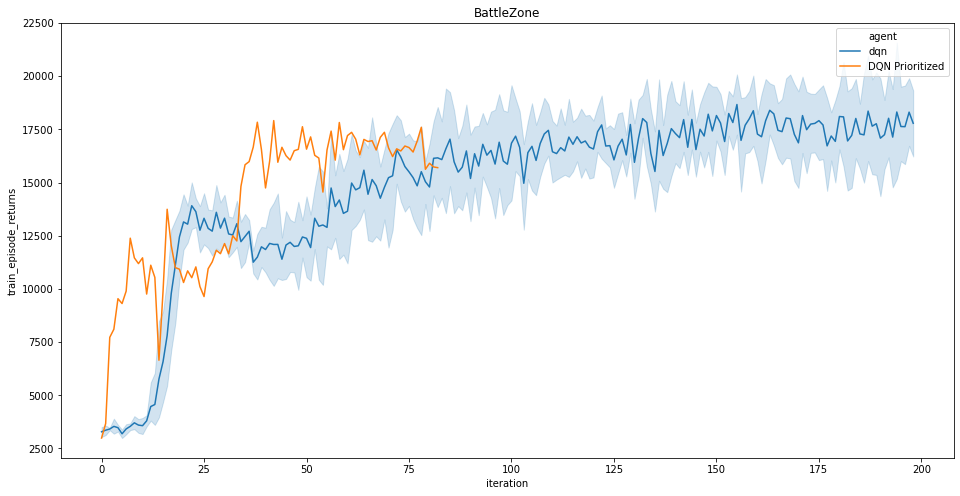

In [17]:
# @title Plot training results.

import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16,8))
sns.lineplot(
    x='iteration', y='train_episode_returns', hue='agent',
    data=comparison, ax=ax)
plt.title(GAME)
plt.show()

# DQN Plain

In [4]:
LOG_PATH = os.path.join(BASE_PATH, 'plain_dqn', GAME)

In [5]:
# @title Create the DQN with Plain setup
from dopamine.replay_memory import prioritized_replay_buffer
import tensorflow as tf

def create_plain_dqn_agent(sess, environment, summary_writer=None):
  """The Runner class will expect a function of this type to create an agent."""
  return dqn_agent.DQNAgent(sess, num_actions=environment.action_space.n)

plain_dqn_config = """
import dopamine.discrete_domains.atari_lib
import dopamine.discrete_domains.run_experiment
import dopamine.agents.dqn.dqn_agent
import dopamine.replay_memory.circular_replay_buffer
import gin.tf.external_configurables

DQNAgent.gamma = 0.99
DQNAgent.update_horizon = 1
DQNAgent.min_replay_history = 20000  # agent steps
DQNAgent.update_period = 4
DQNAgent.target_update_period = 8000  # agent steps
DQNAgent.epsilon_train = 0.01
DQNAgent.epsilon_eval = 0.001
DQNAgent.epsilon_decay_period = 250000  # agent steps
DQNAgent.tf_device = '/gpu:0'  # use '/cpu:*' for non-GPU version
DQNAgent.optimizer = @tf.train.RMSPropOptimizer()

tf.train.RMSPropOptimizer.learning_rate = 0.00025
tf.train.RMSPropOptimizer.decay = 0.95
tf.train.RMSPropOptimizer.momentum = 0.0
tf.train.RMSPropOptimizer.epsilon = 0.00001
tf.train.RMSPropOptimizer.centered = True

atari_lib.create_atari_environment.game_name = '{}'
# Sticky actions with probability 0.25, as suggested by (Machado et al., 2017).
atari_lib.create_atari_environment.sticky_actions = True
create_agent.agent_name = 'dqn'
Runner.num_iterations = 200
Runner.training_steps = 250000  # agent steps
Runner.evaluation_steps = 125000  # agent steps
Runner.max_steps_per_episode = 27000  # agent steps

WrappedReplayBuffer.replay_capacity = 1000000
WrappedReplayBuffer.batch_size = 32
""".format(GAME)
gin.parse_config(plain_dqn_config, skip_unknown=False)

# Create the runner class with this agent. We use very small numbers of steps
# to terminate quickly, as this is mostly meant for demonstrating how one can
# use the framework.
plain_dqn_runner = run_experiment.TrainRunner(LOG_PATH, create_plain_dqn_agent)

Instructions for updating:
non-resource variables are not supported in the long term


Instructions for updating:
non-resource variables are not supported in the long term


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [6]:
# @title Train MyRandomDQNAgent.
print('Will train agent, please be patient, may be a while...')
plain_dqn_runner.run_experiment()
print('Done training!')

Will train agent, please be patient, may be a while...


KeyboardInterrupt: 

In [7]:
# @title Load the training logs.
plain_dqn_data = colab_utils.read_experiment(
    LOG_PATH, verbose=True, summary_keys=['train_episode_returns'])
plain_dqn_data['agent'] = 'DQN Plain'
plain_dqn_data['run_number'] = 1
experimental_data[GAME] = experimental_data[GAME].merge(plain_dqn_data, how='outer')

Reading statistics from: running-data/plain_dqn/Asterix//logs/log_6


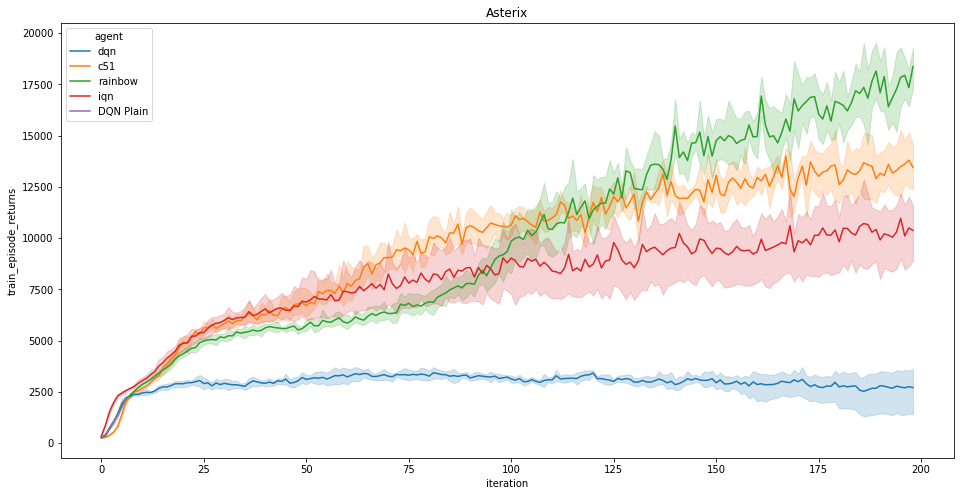

In [9]:
# @title Plot training results.

import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16,8))
sns.lineplot(
    x='iteration', y='train_episode_returns', hue='agent',
    data=experimental_data[GAME], ax=ax)
plt.title(GAME)
plt.show()

# DQN Prioritized SR

In [14]:
LOG_PATH = os.path.join(BASE_PATH, 'prioritized_srdqn', GAME)

In [17]:
# @title Create the DQN with prioritized replay
from dopamine.replay_memory import prioritized_replay_buffer
import dopamine.discrete_domains.atari_lib.SRNetwork
import tensorflow as tf

class PrioritizedSRDQNAgent(dqn_agent.DQNAgent):
  def __init__(self, sess, num_actions):
    """This maintains all the DQN default argument values."""
    super().__init__(sess, num_actions)
    self._replay_scheme = 'prioritized'

  def _build_networks(self):
    """Builds the Q-value network computations needed for acting and training.

    These are:
      self.online_convnet: For computing the current state's Q-values.
      self.target_convnet: For computing the next state's target Q-values.
      self.sr_convnet: For computing the sr for state-action pair
      self._net_outputs: The actual Q-values.
      self._q_argmax: The action maximizing the current state's Q-values.
      self._replay_net_outputs: The replayed states' Q-values.
      self._replay_next_target_net_outputs: The replayed next states' target
        Q-values (see Mnih et al., 2015 for details).
    """

    # _network_template instantiates the model and returns the network object.
    # The network object can be used to generate different outputs in the graph.
    # At each call to the network, the parameters will be reused.
    self.online_convnet = self._create_network(name='Online')
    self.target_convnet = self._create_network(name='Target')
    self.sr_convnet = SRNetwork(self.num_actions, atari_lib.NATURE_DQN_STACK_SIZE)
    self._net_outputs = self.online_convnet(self.state_ph)
    # TODO(bellemare): Ties should be broken. They are unlikely to happen when
    # using a deep network, but may affect performance with a linear
    # approximation scheme.
    self._q_argmax = tf.argmax(self._net_outputs.q_values, axis=1)[0]
    self._replay_net_outputs = self.online_convnet(self._replay.states)
    self._replay_next_target_net_outputs = self.target_convnet(
        self._replay.next_states)

  def _build_replay_buffer(self, use_staging):
    return prioritized_replay_buffer.WrappedPrioritizedReplayBuffer(
        observation_shape=self.observation_shape,
        stack_size=self.stack_size,
        use_staging=use_staging,
        update_horizon=self.update_horizon,
        gamma=self.gamma,
        observation_dtype=self.observation_dtype.as_numpy_dtype)

  def _build_train_op(self):
    """Builds a training op.
    Returns:
      train_op: An op performing one step of training from replay data.
    """
    replay_action_one_hot = tf.one_hot(
        self._replay.actions, self.num_actions, 1., 0., name='action_one_hot')
    replay_chosen_q = tf.reduce_sum(
        self._replay_net_outputs.q_values * replay_action_one_hot,
        axis=1,
        name='replay_chosen_q')

    target = tf.stop_gradient(self._build_target_q_op())
    loss = tf.compat.v1.losses.huber_loss(
        target, replay_chosen_q, reduction=tf.losses.Reduction.NONE)
    # The original prioritized experience replay uses a linear exponent
    # schedule 0.4 -> 1.0. Comparing the schedule to a fixed exponent of 0.5
    # on 5 games (Asterix, Pong, Q*Bert, Seaquest, Space Invaders) suggested
    # a fixed exponent actually performs better, except on Pong.
    probs = self._replay.transition['sampling_probabilities']
    loss_weights = 1.0 / tf.sqrt(probs + 1e-10)
    loss_weights /= tf.reduce_max(loss_weights)

    # Rainbow and prioritized replay are parametrized by an exponent alpha,
    # but in both cases it is set to 0.5 - for simplicity's sake we leave it
    # as is here, using the more direct tf.sqrt(). Taking the square root
    # "makes sense", as we are dealing with a squared loss.
    # Add a small nonzero value to the loss to avoid 0 priority items. While
    # technically this may be okay, setting all items to 0 priority will cause
    # troubles, and also result in 1.0 / 0.0 = NaN correction terms.
    update_priorities_op = self._replay.tf_set_priority(
        self._replay.indices, tf.sqrt(loss + 1e-10))

    # Weight the loss by the inverse priorities.
    loss = loss_weights * loss
    
    with tf.control_dependencies([update_priorities_op]):
      if self.summary_writer is not None:
        with tf.compat.v1.variable_scope('Losses'):
          tf.compat.v1.summary.scalar('HuberLoss', tf.reduce_mean(loss))
      return self.optimizer.minimize(tf.reduce_mean(loss))

  def _store_transition(self,
                        last_observation,
                        action,
                        reward,
                        is_terminal,
                        priority=None):
    priority = self._replay.memory.sum_tree.max_recorded_priority
    if not self.eval_mode:
      self._replay.add(last_observation, action, reward, is_terminal, priority)
    
  def _record_observation(self, observation):
    """Records an observation and update state.

    Extracts a frame from the observation vector and overwrites the oldest
    frame in the state buffer.

    Args:
      observation: numpy array, an observation from the environment.
    """
    # Set current observation. We do the reshaping to handle environments
    # without frame stacking.
    self._observation = np.reshape(observation, self.observation_shape)
    # Swap out the oldest frame with the current frame.
    self.state = np.roll(self.state, -1, axis=-1)
    print(self.state.shape)
    self.state[0, ..., -1] = self._observation
    
def create_prioritized_srdqn_agent(sess, environment, summary_writer=None):
  """The Runner class will expect a function of this type to create an agent."""
  return PrioritizedSRDQNAgent(sess, num_actions=environment.action_space.n)

prioritized_srdqn_config = """
import dopamine.discrete_domains.atari_lib
import dopamine.discrete_domains.run_experiment
import dopamine.agents.dqn.dqn_agent
import dopamine.replay_memory.prioritized_replay_buffer
import gin.tf.external_configurables

DQNAgent.gamma = 0.99
DQNAgent.update_horizon = 1
DQNAgent.min_replay_history = 20000  # agent steps
DQNAgent.update_period = 4
DQNAgent.target_update_period = 8000  # agent steps
DQNAgent.epsilon_train = 0.01
DQNAgent.epsilon_eval = 0.001
DQNAgent.epsilon_decay_period = 250000  # agent steps
DQNAgent.tf_device = '/gpu:0'  # use '/cpu:*' for non-GPU version
DQNAgent.optimizer = @tf.train.RMSPropOptimizer()

tf.train.RMSPropOptimizer.learning_rate = 0.00025
tf.train.RMSPropOptimizer.decay = 0.95
tf.train.RMSPropOptimizer.momentum = 0.0
tf.train.RMSPropOptimizer.epsilon = 0.00001
tf.train.RMSPropOptimizer.centered = True

atari_lib.create_atari_environment.game_name = '{}'
# Sticky actions with probability 0.25, as suggested by (Machado et al., 2017).
atari_lib.create_atari_environment.sticky_actions = True
create_agent.agent_name = 'dqn'
Runner.num_iterations = 200
Runner.training_steps = 250000  # agent steps
Runner.evaluation_steps = 125000  # agent steps
Runner.max_steps_per_episode = 27000  # agent steps

WrappedPrioritizedReplayBuffer.replay_capacity = 1000000
WrappedPrioritizedReplayBuffer.batch_size = 32
""".format(GAME)
gin.parse_config(prioritized_srdqn_config, skip_unknown=False)

# Create the runner class with this agent. We use very small numbers of steps
# to terminate quickly, as this is mostly meant for demonstrating how one can
# use the framework.
prioritized_srdqn_runner = run_experiment.TrainRunner(LOG_PATH, create_prioritized_srdqn_agent)

ModuleNotFoundError: No module named 'dopamine.discrete_domains.atari_lib.SRNetwork'; 'dopamine.discrete_domains.atari_lib' is not a package

In [7]:
# @title Train MyRandomDQNAgent.
print('Will train agent, please be patient, may be a while...')
prioritized_srdqn_runner.run_experiment()
print('Done training!')

Will train agent, please be patient, may be a while...


KeyboardInterrupt: 

# Upload to git



1.   manually clone the repo to local computer
2.   download this file and overwrite into the repo
3.   resolve conflicts, push to origin



# Try out stable-baselines

In [3]:
from stable_baselines3.common.env_util import make_atari_env
from stable_baselines3.common.vec_env import VecFrameStack
from stable_baselines3 import DQN

# There already exists an environment generator
# that will make and wrap atari environments correctly.
# Here we are also multi-worker training (n_envs=4 => 4 environments)
env = make_atari_env('PongNoFrameskip-v4', n_envs=1, seed=0)
# Frame-stacking with 4 frames
env = VecFrameStack(env, n_stack=1)

model = DQN('CnnPolicy', env, verbose=1, device='cuda')
model.learn(total_timesteps=25000)

obs = env.reset()
while True:
    action, _states = model.predict(obs)
    obs, rewards, dones, info = env.step(action)

Using cpu device
Wrapping the env in a VecTransposeImage.


C:\Users\apple\anaconda3\envs\dopamine-need\lib\site-packages\stable_baselines3\common\buffers.py:200: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 14.13GB > 7.82GB
  "This system does not have apparently enough memory to store the complete "


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.6e+03  |
|    ep_rew_mean      | -20.2    |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 253      |
|    time_elapsed     | 14       |
|    total timesteps  | 3580     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.54e+03 |
|    ep_rew_mean      | -20.4    |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 254      |
|    time_elapsed     | 27       |
|    total timesteps  | 7024     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.54e+03 |
|    ep_rew_mean      | -20.5    |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes       

KeyboardInterrupt: 

In [ ]:
env.close()

# Make the plot

In [7]:
pip install pickle5

  Created wheel for pickle5: filename=pickle5-0.0.11-cp36-cp36m-win_amd64.whl size=123893 sha256=fd147ad8052096874da0936cfda1956f100c73b8c38b1dfd6769f984e8478a2c
  Stored in directory: c:\users\apple\appdata\local\pip\cache\wheels\f9\b7\be\bf9768ab0daa28fa4b386f3ad1bac5dd4d9c349c60e83b24e3
Successfully built pickle5
Note: you may need to restart the kernel to use updated packages.


In [32]:
GAME = 'Berzerk'
LOG_PATH = os.path.join(BASE_PATH, 'prioritized_srdqn_normalized', GAME)

In [33]:
# @title Load the training logs.
plain_dqn_data = colab_utils.read_experiment(
    LOG_PATH, verbose=True, summary_keys=['train_episode_returns'])
plain_dqn_data['agent'] = 'PER-SR-magnitude'
plain_dqn_data['run_number'] = 1
experimental_data[GAME] = experimental_data[GAME].merge(plain_dqn_data, how='outer')

Reading statistics from: running-data\prioritized_srdqn_normalized\Berzerk\logs\log_190


In [65]:
GAME = 'Boxing'
LOG_PATH = os.path.join(BASE_PATH, 'prioritized_srdqn_new', GAME)

In [620]:
plain_dqn_data = colab_utils.read_experiment(
    LOG_PATH, verbose=True, summary_keys=['train_episode_returns'])
plain_dqn_data['agent'] = 'PER-SR-new'
plain_dqn_data['run_number'] = 1
experimental_data[GAME] = experimental_data[GAME].merge(plain_dqn_data, how='outer')

Reading statistics from: running-data\prioritized_srdqn_new\ChopperCommand\logs\log_58


In [34]:
LOG_PATH = os.path.join(BASE_PATH, 'prioritized_dqn', GAME)

In [35]:
plain_dqn_data = colab_utils.read_experiment(
    LOG_PATH, verbose=True, summary_keys=['train_episode_returns'])
plain_dqn_data['agent'] = 'PER'
plain_dqn_data['run_number'] = 1
experimental_data[GAME] = experimental_data[GAME].merge(plain_dqn_data, how='outer')

Reading statistics from: running-data\prioritized_dqn\Berzerk\logs\log_199


In [36]:
data = experimental_data[GAME]
comparison = pd.concat([data[data['agent'] == 'PER'], data[data['agent'] == 'PER-SR-magnitude']])
# comparison = pd.concat([data[data['agent'] == 'PER'], data[data['agent'] == 'PER-SR-new']])
# comparison = pd.concat([data[data['agent'] == 'PER'], data[data['agent'] == 'PER-SR-magnitude'], data[data['agent'] == 'PER-SR-sample']])

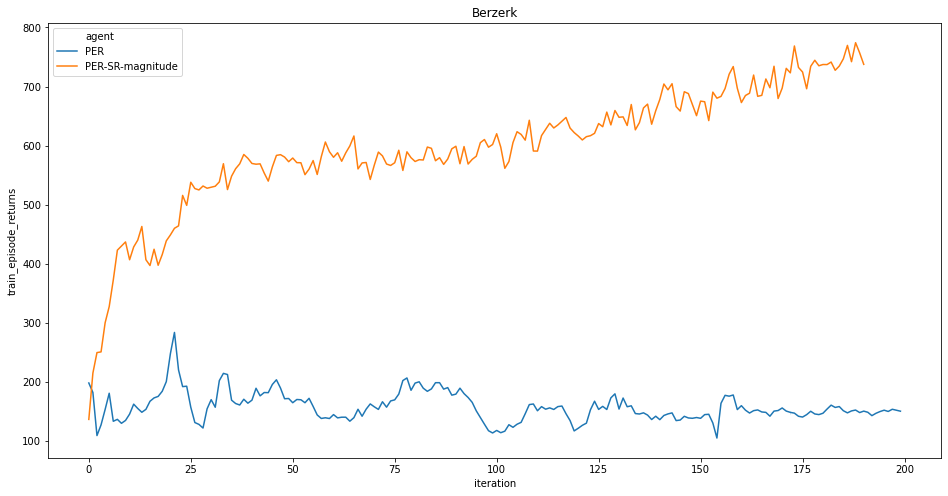

In [37]:
# @title Plot training results.

import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16,8))
sns.lineplot(
    x='iteration', y='train_episode_returns', hue='agent',
    data=comparison, ax=ax)
plt.title(GAME)
plt.show()

In [15]:
def relative_performance(game):
    GAME = game
    LOG_PATH = os.path.join(BASE_PATH, 'prioritized_srdqn_normalized', GAME)
    
    # @title Load the training logs.
    plain_dqn_data = colab_utils.read_experiment(
    LOG_PATH, verbose=True, summary_keys=['train_episode_returns'])
    plain_dqn_data['agent'] = 'PER-SR-magnitude'
    plain_dqn_data['run_number'] = 1
    experimental_data[GAME] = experimental_data[GAME].merge(plain_dqn_data, how='outer')
    
    LOG_PATH = os.path.join(BASE_PATH, 'prioritized_dqn', GAME)
    plain_dqn_data = colab_utils.read_experiment(
    LOG_PATH, verbose=True, summary_keys=['train_episode_returns'])
    plain_dqn_data['agent'] = 'PER'
    plain_dqn_data['run_number'] = 1
    experimental_data[GAME] = experimental_data[GAME].merge(plain_dqn_data, how='outer')
    
    data = experimental_data[GAME]
    comparison = data[data['agent'] == 'PER-SR-magnitude']['train_episode_returns'].max() / data[data['agent'] == 'PER']['train_episode_returns'].max() - 1
    
    return comparison

In [16]:
relative_performance('BattleZone')

Reading statistics from: running-data\prioritized_srdqn_normalized\BattleZone\logs\log_199
Reading statistics from: running-data\prioritized_dqn\BattleZone\logs\log_199


0.23530465338427953

In [17]:
games = ['Asterix', 'BattleZone', 'Berzerk', 'Boxing']
all_ratio = []
for game in games:
    ratio = relative_performance(game)
    all_ratio.append([game, ratio])
    
ratios = pd.DataFrame(all_ratio, columns=['game', 'ratio'])

Reading statistics from: running-data\prioritized_srdqn_normalized\Asterix\logs\log_199
Reading statistics from: running-data\prioritized_dqn\Asterix\logs\log_194
Reading statistics from: running-data\prioritized_srdqn_normalized\BattleZone\logs\log_199
Reading statistics from: running-data\prioritized_dqn\BattleZone\logs\log_199
Reading statistics from: running-data\prioritized_srdqn_normalized\Berzerk\logs\log_190
Reading statistics from: running-data\prioritized_dqn\Berzerk\logs\log_172
Reading statistics from: running-data\prioritized_srdqn_normalized\Boxing\logs\log_175
Reading statistics from: running-data\prioritized_dqn\Boxing\logs\log_196


In [18]:
ratios.head()

,game,ratio
0,Asterix,-0.150088
1,BattleZone,0.235305
2,Berzerk,1.726458
3,Boxing,0.413607


[Text(0, 0, '-25%'),
 Text(0, 0, '0%'),
 Text(0, 0, '25%'),
 Text(0, 0, '50%'),
 Text(0, 0, '75%'),
 Text(0, 0, '100%'),
 Text(0, 0, '125%'),
 Text(0, 0, '150%'),
 Text(0, 0, '175%'),
 Text(0, 0, '200%')]

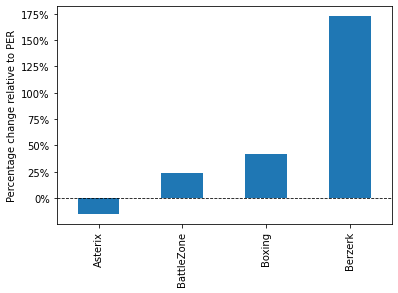

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = ratios.sort_values(by=['ratio']).plot.bar(x="game", y="ratio")
ax.set_xlabel("")
ax.set_ylabel("Percentage change relative to PER")
ax.axhline(y = 0, color='k', lw=0.8, ls='--')
ax.get_legend().remove()

# set y axis in percentage
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])